In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
import time

Epoch [1/10], Loss: 1.9650, Accuracy: 56.840%
Epoch [2/10], Loss: 1.8336, Accuracy: 66.580%
Epoch [3/10], Loss: 1.7653, Accuracy: 73.950%
Epoch [4/10], Loss: 1.6810, Accuracy: 82.610%
Epoch [5/10], Loss: 1.6477, Accuracy: 83.890%
Epoch [6/10], Loss: 1.6358, Accuracy: 84.290%
Epoch [7/10], Loss: 1.6292, Accuracy: 84.780%
Epoch [8/10], Loss: 1.6245, Accuracy: 85.030%
Epoch [9/10], Loss: 1.6214, Accuracy: 85.170%
Epoch [10/10], Loss: 1.6186, Accuracy: 85.320%


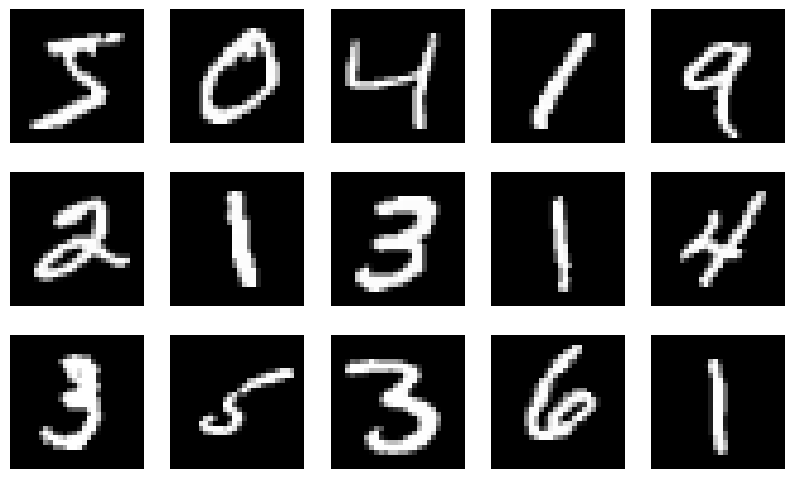

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.fc(x)

input_size, hidden_size, output_size = 784, 25, 10
learning_rate, batch_size, num_epochs = 0.1, 32, 10
num_batch = 64

train_DATA = MNIST(root='.', train=True, transform=ToTensor(), download=True)
train_loader = DataLoader(train_DATA, batch_size=batch_size, shuffle=True)
val_data = MNIST(root='.', train=False, transform=ToTensor(), download=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_data = MNIST(root='.', train=False, transform=ToTensor(), download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


model = MLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

val_loss_prev, count = float('inf'), 0
for epoch in range(num_epochs):
    for x, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(x.view(-1, input_size)), y)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        val_loss, correct = 0, 0
        for x, y in val_loader:
            outputs = model(x.view(-1, input_size))
            val_loss += criterion(outputs, y).item() * x.size(0)
            correct += (outputs.argmax(dim=1) == y).sum().item()
        val_loss /= len(val_loader.dataset)

    accuracy = correct / len(val_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss:.4f}, 'f'Accuracy: {accuracy:.3%}')

    if val_loss > val_loss_prev:
        count += 1
        if count == 15:
            print('Early stopping')
            break
    else:
        val_loss_prev, count = val_loss, 0
train_DATA = MNIST(root='.', train=True, transform=ToTensor(), download=True)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10,6))
for i, ax in enumerate(axes.flat):
    image, label = train_DATA[i]
    ax.imshow(image[0], cmap='gray')
    ax.axis('off')

# Mostrar la figura
plt.show()

In [ ]:
train_DATA.data.shape

torch.Size([60000, 28, 28])

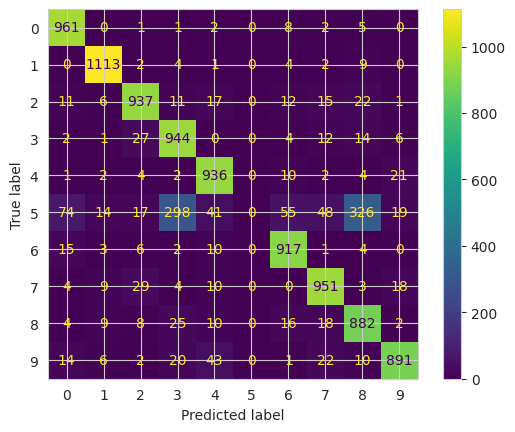

In [42]:
true_labels = []
predicted_labels = []
for images, labels in test_loader:
    images = images.view(-1, input_size)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted.numpy())

confusion_mat = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=list(range(10)))
disp.plot()
plt.show()


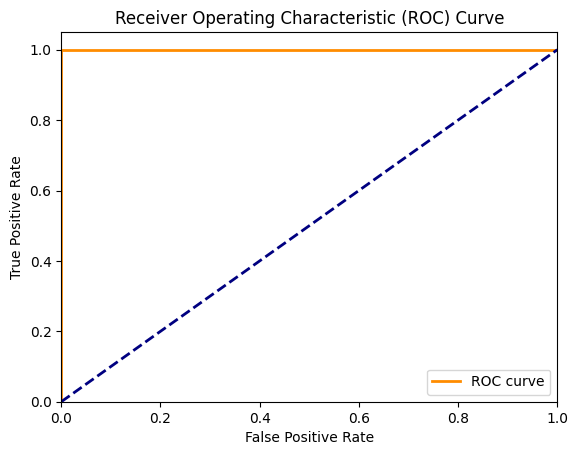

In [ ]:
with torch.no_grad():
   
    for images, labels in test_loader:
        images = images.reshape(-1, input_size)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1) # Aplica softmax a las puntuaciones
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        y_true = labels.tolist()
        y_pred = predicted.tolist()
        y_scores = probs[:, 1].tolist() # Convierte probs[:, 1] en una lista
        

fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=1)

# Trazar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = '')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(num_epochs):
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, input_size)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= train_total
    train_acc = train_correct / train_total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    test_loss = 0.0
    test_total = 0
    test_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, input_size)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        test_loss /= test_total
        test_acc = test_correct / test_total
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch+1, num_epochs, train_loss, train_acc, test_loss, test_acc))


Epoch [1/10], Train Loss: 1.5654, Train Acc: 0.9170, Test Loss: 1.5605, Test Acc: 0.9197
Epoch [2/10], Train Loss: 1.5605, Train Acc: 0.9205, Test Loss: 1.5566, Test Acc: 0.9226
Epoch [3/10], Train Loss: 1.5565, Train Acc: 0.9233, Test Loss: 1.5527, Test Acc: 0.9253
Epoch [4/10], Train Loss: 1.5532, Train Acc: 0.9252, Test Loss: 1.5501, Test Acc: 0.9266
Epoch [5/10], Train Loss: 1.5503, Train Acc: 0.9272, Test Loss: 1.5474, Test Acc: 0.9286
Epoch [6/10], Train Loss: 1.5478, Train Acc: 0.9290, Test Loss: 1.5453, Test Acc: 0.9291
Epoch [7/10], Train Loss: 1.5455, Train Acc: 0.9305, Test Loss: 1.5432, Test Acc: 0.9310
Epoch [8/10], Train Loss: 1.5433, Train Acc: 0.9321, Test Loss: 1.5412, Test Acc: 0.9322
Epoch [9/10], Train Loss: 1.5414, Train Acc: 0.9336, Test Loss: 1.5401, Test Acc: 0.9322
Epoch [10/10], Train Loss: 1.5397, Train Acc: 0.9349, Test Loss: 1.5380, Test Acc: 0.9345


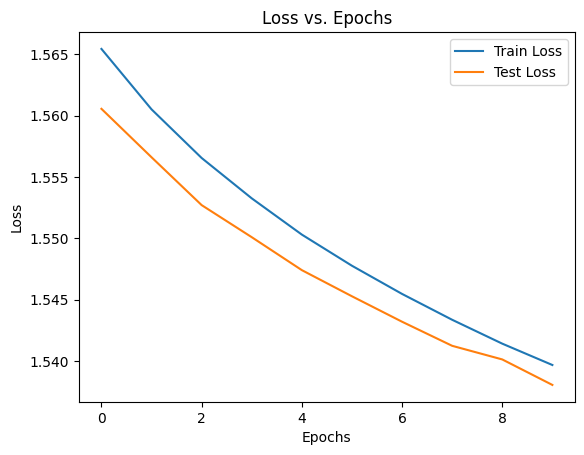

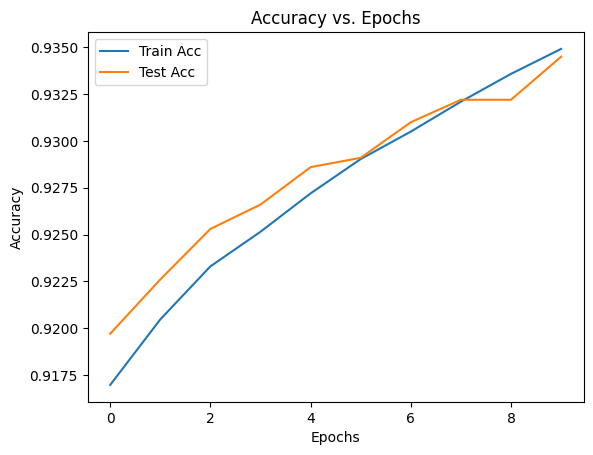

In [ ]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

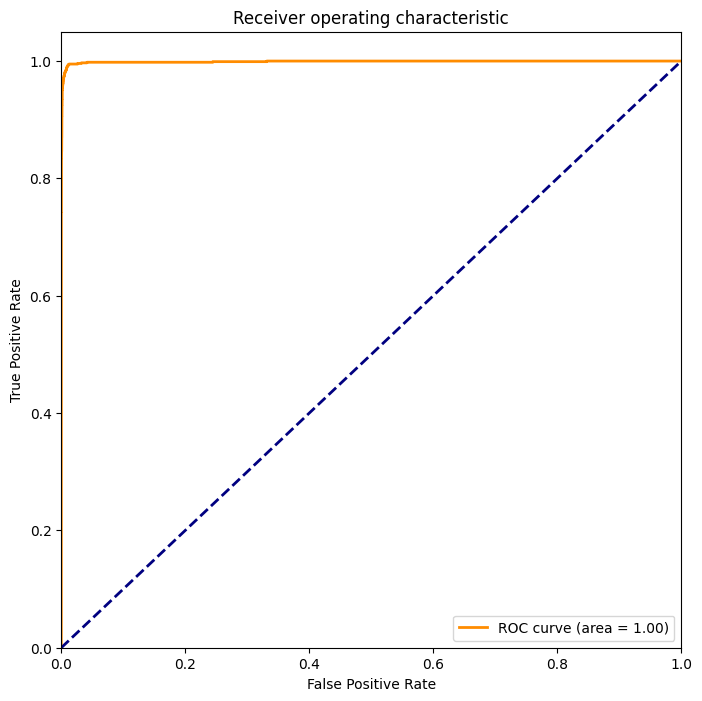

ROC AUC: 0.9989
EER threshold: 0.1023
Detection error rate: 1.0000


In [ ]:
# Define la clase positiva y negativa
rut = '0'
if int(rut[-1]) == 0:
    positive_class = 0
else:
    positive_class = int(rut[-1])
negative_class = [i for i in range(10) if i != positive_class]

# Crea las listas de etiquetas verdaderas y puntajes del modelo
y_true = []
y_score = []
model.eval()  
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, input_size)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_score.extend(probs[:, positive_class].tolist())

y_true = np.array(y_true)
y_score = np.array(y_score)

# Calcula la curva ROC y el área bajo la curva
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=positive_class)
roc_auc = roc_auc_score(y_true == positive_class, y_score)
eer_threshold = thresholds[np.argmin(np.abs(fpr + tpr - 1))]

# Calcula la curva DET y el punto EER
fpr_det, fnr_det, thresholds_det = roc_curve(y_true, y_score, pos_label=positive_class, drop_intermediate=False)
detection_error_rate = fnr_det[np.argmin(np.abs(fpr_det - (1 - eer_threshold)))]

# Grafica la curva ROC
plt.figure(figsize=(8, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

# Imprime los resultados
print('ROC AUC: {:.4f}'.format(roc_auc))
print('EER threshold: {:.4f}'.format(eer_threshold))
print('Detection error rate: {:.4f}'.format(detection_error_rate))

## EJERCICIO 2

In [ ]:
def train_model(lr):
# Datos de entrenamiento 
    x_train = torch.randn(100, 10)
    y_train = torch.randint(0, 2, (100,))
    x_val = torch.randn(50, 10)
    y_val = torch.randint(0, 2, (50,))
# función de pérdida
    model = nn.Linear(10, 2)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    train_loss_values = []
    train_accuracies_all = []
    val_loss_values = []
    val_accuracies_all = []

 #entramos ahora con los nuevos datos
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_train)
        train_loss = loss_fn(y_pred, y_train)
        train_loss.backward()
        optimizer.step()
        train_loss_values.append(train_loss.item())

        # Evaluación del conjunto de entrenamiento
        model.eval()
        with torch.no_grad():
            train_correct = (y_pred.argmax(dim=1) == y_train).sum().item()
            train_accuracy = train_correct / len(y_train)
            train_accuracies_all.append(train_accuracy)

        # Evaluación del conjunto de validación
        with torch.no_grad():
            y_pred = model(x_val)
            val_loss = loss_fn(y_pred, y_val)
            val_loss_values.append(val_loss.item())
            val_correct = (y_pred.argmax(dim=1) == y_val).sum().item()
            val_accuracy = val_correct / len(y_val)
            val_accuracies_all.append(val_accuracy)

    return train_loss_values, train_accuracies_all, val_loss_values, val_accuracies_all

# Valores de tasa de aprendizaje
learning_rates = [0.01, 0.1, 1, 10]
for lr in learning_rates:
    print(f"Evaluacion de la tasa de aprendizaje: {lr}")
    train_loss_values_all = []
    train_accuracies_all_all = []
    val_loss_values_all = []
    val_accuracies_all_all = []
    time_all = []

    num_repeats = 5    
    for i in range(num_repeats):
        start_time = time.time()
        train_loss_values, train_accuracies_all, val_loss_values, val_accuracies_all = train_model(lr)
        end_time = time.time()
        time_all.append(end_time - start_time)
        train_loss_values_all.append(train_loss_values)
        train_accuracies_all_all.append(train_accuracies_all)
        val_loss_values_all.append(val_loss_values)
        val_accuracies_all_all.append(val_accuracies_all)
        
    # Obtener los valores promedio y desviación estándar de las métricas de entrenamiento y validación
    avg_train_loss = np.mean(train_loss_values_all, axis=0)[-1]
    std_train_loss = np.std(train_loss_values_all, axis=0)[-1]
    avg_train_accuracy = np.mean(train_accuracies_all_all, axis=0)[-1]
    std_train_accuracy = np.std(train_accuracies_all_all, axis=0)[-1]
    avg_val_loss = np.mean(val_loss_values_all, axis=0)[-1]
    std_val_loss = np.std(val_loss_values_all, axis=0)[-1]
    avg_val_accuracy = np.mean(val_accuracies_all_all, axis=0)[-1]
    avg_time = np.mean(time_all)
    std_time = np.std(time_all)



Evaluacion de la tasa de aprendizaje: 0.01
Evaluacion de la tasa de aprendizaje: 0.1
Evaluacion de la tasa de aprendizaje: 1
Evaluacion de la tasa de aprendizaje: 10


##EJERCIO 3


In [ ]:
def train_model(lr, num_hidden_units=None):
    if num_hidden_units is None:
        model = nn.Linear(10, 2)
    else:
        model = nn.Sequential(
            nn.Linear(10, num_hidden_units),
            nn.ReLU(),
            nn.Linear(num_hidden_units, 2)
        )
    loss_fn = nn.CrossEntropyLoss()

    x_train = torch.randn(100, 10)
    y_train = torch.randint(0, 2, (100,))
    x_val = torch.randn(100, 10)
    y_val = torch.randint(0, 2, (100,))

    optimizer = optim.SGD(model.parameters(), lr=lr)

    num_epochs = 1000
    best_loss = float('inf')
    num_bad_epochs = 0
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_val_pred = model(x_val)
            val_loss = loss_fn(y_val_pred, y_val)
            if val_loss < best_loss:
                best_loss = val_loss
                num_bad_epochs = 0
            else:
                num_bad_epochs += 1
                if num_bad_epochs > 1000:
                    break

    with torch.no_grad():
        y_val_pred = model(x_val)
        val_loss = loss_fn(y_val_pred, y_val)
        val_acc = (y_val_pred.argmax(dim=1) == y_val).float().mean().item()

    return val_acc


learning_rate = 0.1
num_repeats = 5
num_units_list = [None, 1, 10, 25, 100]

for num_units in num_units_list:
    print(f"Evaluando número de unidades: {num_units}")
    val_acc_all = []
    for i in range(num_repeats):
        val_acc = train_model(learning_rate, num_hidden_units=num_units)
        val_acc_all.append(val_acc)
    avg_val_acc = np.mean(val_acc_all)
    std_val_acc = np.std(val_acc_all)
    print(f"Exactitud de validación promedio: {avg_val_acc:.4f} +/- {std_val_acc:.4f}")


lr_list = [0.01, 0.1, 0.5, 1.0]
num_repeats = 5
hidden_units = [None, 1, 10, 25, 100]

for lr in lr_list:
    for num_hidden_units in hidden_units:
        print(f"Evaluando tasa de aprendizaje: {lr}, número de unidades ocultas: {num_hidden_units}")
        val_acc_all = []
        time_all = []
        for i in range(num_repeats):
            start_time = time.time()
            val_acc = train_model(lr=lr, num_hidden_units=num_hidden_units)
            end_time = time.time()
            time_all.append(end_time - start_time)
            val_acc_all.append(val_acc)
        avg_val_acc = np.mean(val_acc_all)
        std_val_acc = np.std(val_acc_all)
        avg_time = np.mean(time_all)
        std_time = np.std(time_all)
        print(f"Exactitud de validación promedio: {avg_val_acc:.4f} +/- {std_val_acc:.4f}")
        print(f"Tiempo de entrenamiento promedio: {avg_time:.4f}+/- {std_val_acc:.4f}")


Evaluando número de unidades: None
Exactitud de validación promedio: 0.5140 +/- 0.0393
Evaluando número de unidades: 1
Exactitud de validación promedio: 0.5180 +/- 0.0349
Evaluando número de unidades: 10
Exactitud de validación promedio: 0.5300 +/- 0.0533
Evaluando número de unidades: 25
Exactitud de validación promedio: 0.5440 +/- 0.0344
Evaluando número de unidades: 100
Exactitud de validación promedio: 0.5000 +/- 0.0510
Evaluando tasa de aprendizaje: 0.01, número de unidades ocultas: None
Exactitud de validación promedio: 0.5240 +/- 0.0595
Tiempo de entrenamiento promedio: 0.2844+/- 0.0595
Evaluando tasa de aprendizaje: 0.01, número de unidades ocultas: 1
Exactitud de validación promedio: 0.4880 +/- 0.0462
Tiempo de entrenamiento promedio: 0.6378+/- 0.0462
Evaluando tasa de aprendizaje: 0.01, número de unidades ocultas: 10
Exactitud de validación promedio: 0.4820 +/- 0.0538
Tiempo de entrenamiento promedio: 0.7230+/- 0.0538
Evaluando tasa de aprendizaje: 0.01, número de unidades ocu

##EJERCICIO 4


In [ ]:
def train_model(lr, num_hidden_units=None):
    if num_hidden_units is None:
        model = nn.Linear(10, 2)
    else:
        model = nn.Sequential(
            nn.Linear(10, num_hidden_units),
            nn.ReLU(),
            nn.Linear(num_hidden_units, 2)
        )
    loss_fn = nn.CrossEntropyLoss()

    x_train = torch.randn(100, 10)
    y_train = torch.randint(0, 2, (100,))
    x_val = torch.randn(100, 10)
    y_val = torch.randint(0, 2, (100,))

    optimizer = optim.SGD(model.parameters(), lr=lr)

    num_epochs = 1000
    best_loss = float('inf')
    num_bad_epochs = 0
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_val_pred = model(x_val)
            val_loss = loss_fn(y_val_pred, y_val)
            if val_loss < best_loss:
                best_loss = val_loss
                num_bad_epochs = 0
            else:
                num_bad_epochs += 1
                if num_bad_epochs > 1000:
                    break

    with torch.no_grad():
        y_val_pred = model(x_val)
        val_loss = loss_fn(y_val_pred, y_val)
        val_acc = (y_val_pred.argmax(dim=1) == y_val).float().mean().item()

    return val_acc


learning_rate = 0.1
num_repeats = 5
num_units_list = [None, 1, 10, 25, 100]

for num_units in num_units_list:
    print(f"Evaluando número de unidades: {num_units}")
    val_acc_all = []
    for i in range(num_repeats):
        val_acc = train_model(learning_rate, num_hidden_units=num_units)
        val_acc_all.append(val_acc)
    avg_val_acc = np.mean(val_acc_all)
    std_val_acc = np.std(val_acc_all)
    print(f"Exactitud de validación promedio: {avg_val_acc:.4f} +/- {std_val_acc:.4f}")


lr_list = [0.01, 0.1, 0.5, 1.0]
num_repeats = 5
hidden_units = [None, 1, 10, 25, 100]

for lr in lr_list:
    for num_hidden_units in hidden_units:
        print(f"Evaluando tasa de aprendizaje: {lr}, número de unidades ocultas: {num_hidden_units}")
        val_acc_all = []
        time_all = []
        for i in range(num_repeats):
            start_time = time.time()
            val_acc = train_model(lr=lr, num_hidden_units=num_hidden_units)
            end_time = time.time()
            time_all.append(end_time - start_time)
            val_acc_all.append(val_acc)
        avg_val_acc = np.mean(val_acc_all)
        std_val_acc = np.std(val_acc_all)
        avg_time = np.mean(time_all)
        std_time = np.std(time_all)
        print(f"Exactitud de validación promedio: {avg_val_acc:.4f} +/- {std_val_acc:.4f}")
        print(f"Tiempo de entrenamiento promedio: {avg_time:.4f}segundos\n")


Evaluando número de unidades: None
Exactitud de validación promedio: 0.5320 +/- 0.0487
Evaluando número de unidades: 1
Exactitud de validación promedio: 0.5080 +/- 0.0546
Evaluando número de unidades: 10
Exactitud de validación promedio: 0.5120 +/- 0.0349
Evaluando número de unidades: 25
Exactitud de validación promedio: 0.5100 +/- 0.0494
Evaluando número de unidades: 100
Exactitud de validación promedio: 0.5000 +/- 0.0303
Evaluando tasa de aprendizaje: 0.01, número de unidades ocultas: None
Exactitud de validación promedio: 0.4700 +/- 0.0415
Tiempo de entrenamiento promedio: 0.4192segundos

Evaluando tasa de aprendizaje: 0.01, número de unidades ocultas: 1
Exactitud de validación promedio: 0.4820 +/- 0.0500
Tiempo de entrenamiento promedio: 0.5560segundos

Evaluando tasa de aprendizaje: 0.01, número de unidades ocultas: 10
Exactitud de validación promedio: 0.5140 +/- 0.0618
Tiempo de entrenamiento promedio: 0.5776segundos

Evaluando tasa de aprendizaje: 0.01, número de unidades oculta

##EJERCICIO 5


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.fc(x)

input_size, hidden_size, output_size = 784, 25, 10
learning_rate, batch_size, num_epochs = 0.1, 32, 10
weight_decay = 0.001

train_DATA = MNIST(root='.', train=True, transform=ToTensor(), download=True)
train_loader = DataLoader(train_DATA, batch_size=batch_size, shuffle=True)
val_data = MNIST(root='.', train=False, transform=ToTensor(), download=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_data = MNIST(root='.', train=False, transform=ToTensor(), download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


model = MLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

val_loss_prev, count = float('inf'), 0
for epoch in range(num_epochs):
    for x, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(x.view(-1, input_size)), y)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        val_loss, correct = 0, 0
        for x, y in val_loader:
            outputs = model(x.view(-1, input_size))
            val_loss += criterion(outputs, y).item() * x.size(0)
            correct += (outputs.argmax(dim=1) == y).sum().item()
        val_loss /= len(val_loader.dataset)

    accuracy = correct / len(val_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss:.4f}, 'f'Accuracy: {accuracy:.3%}')

    if val_loss > val_loss_prev:
        count += 1
        if count == 1000:
            print('Early stopping')
            break
    else:
        val_loss_prev, count = val_loss, 0

Epoch [1/10], Loss: 2.0323, Accuracy: 47.840%
Epoch [2/10], Loss: 1.8898, Accuracy: 58.180%
Epoch [3/10], Loss: 1.8186, Accuracy: 66.600%
Epoch [4/10], Loss: 1.6908, Accuracy: 82.610%
Epoch [5/10], Loss: 1.6529, Accuracy: 83.920%
Epoch [6/10], Loss: 1.6395, Accuracy: 84.420%
Epoch [7/10], Loss: 1.6316, Accuracy: 84.700%
Epoch [8/10], Loss: 1.6266, Accuracy: 84.890%
Epoch [9/10], Loss: 1.6230, Accuracy: 85.060%
Epoch [10/10], Loss: 1.6198, Accuracy: 85.320%


##EJERCICIO 6


El método de gradiente descendente estocástico con momentum (SGD con momentum) es un algoritmo de optimización utilizado en el entrenamiento de modelos de redes neuronales para mejorar su rendimiento en una tarea dada. El objetivo del SGD con momentum es ajustar los parámetros del modelo para minimizar una función de pérdida, que mide la diferencia entre las predicciones del modelo y los valores reales de los datos de entrenamiento.

El funcionamiento del SGD con momentum se basa en la actualización iterativa de los pesos del modelo mediante el cálculo del gradiente de la función de pérdida y la actualización de los pesos en la dirección opuesta al gradiente. En el SGD con momentum, se utiliza una fracción del vector de actualización anterior para acelerar la convergencia del algoritmo. El momentum ayuda al algoritmo a converger más rápido y a evitar mínimos locales estancados.

Las justificaciones para utilizar SGD con momentum son que es un algoritmo eficiente y efectivo para el entrenamiento de redes neuronales. Además, puede ayudar a evitar mínimos locales y acelerar la convergencia del algoritmo.

Las ventajas del SGD con momentum son que puede ayudar a mejorar la velocidad de convergencia del algoritmo y a evitar mínimos locales estancados. Además, es fácil de implementar y es adecuado para grandes conjuntos de datos.

Las desventajas del SGD con momentum son que puede ser sensible a la elección del momentum y puede requerir más ajustes de hiperparámetros que otros algoritmos de optimización.

Por otro lado, ADAM es un algoritmo de optimización que combina los conceptos de momentum y RMSprop para adaptar el tamaño del paso de aprendizaje para cada parámetro del modelo de manera individual. ADAM es muy eficaz en el entrenamiento de modelos de redes neuronales y suele converger más rápido que SGD con momentum.

La elección del tamaño del mini-batch es un hiperparámetro importante que influye en el entrenamiento del modelo. Un tamaño de mini-batch pequeño actualiza los pesos con más frecuencia, lo que puede hacer que el modelo converja más rápidamente, pero puede generar ruido en el entrenamiento. Un tamaño de mini-batch grande actualiza los pesos con menos frecuencia, lo que puede hacer que el entrenamiento sea más estable pero puede hacer que el modelo converja más lentamente. El tamaño del mini-batch debe elegirse empíricamente y depende de varios factores, como la cantidad de datos de entrenamiento, el tamaño de la red neuronal y la cantidad de memoria disponible. En general, un tamaño de mini-batch de 32 a 256 se considera razonable para la mayoría de los casos de uso.